# FIT File Analysis and Comparison

This notebook analyzes the structure of FIT files to identify differences between recently generated workout files and the example fitfiletools.fit file. The goal is to understand what needs to be modified in the current FIT file generation process to match the reference example as closely as possible.

In [23]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fitdecode
from datetime import datetime
import collections
from pathlib import Path

## Helper Functions to Analyze FIT Files

First, let's create helper functions to extract and analyze the content of FIT files.

In [24]:
def extract_fit_file_structure(fit_file_path):
    """
    Extract the structure and content of a FIT file
    
    Args:
        fit_file_path: Path to the FIT file
        
    Returns:
        Dictionary containing the structure of the FIT file
    """
    fit_structure = {
        'file_id': None,
        'file_creator': None,
        'event': [],
        'device_info': [],
        'user_profile': None,
        'sport': None,
        'zones_target': None,
        'record': [],
        'lap': [],
        'session': None,
        'activity': None,
        'other_messages': collections.defaultdict(list)
    }
    
    try:
        with fitdecode.FitReader(fit_file_path) as fit:
            for frame in fit:
                if isinstance(frame, fitdecode.FitDataMessage):
                    message_type = frame.name.lower()
                    
                    if message_type in fit_structure:
                        if isinstance(fit_structure[message_type], list):
                            # For list types, append the data
                            fields_dict = {field.name: field.value for field in frame.fields}
                            fit_structure[message_type].append(fields_dict)
                        else:
                            # For single-instance types, set the data
                            fields_dict = {field.name: field.value for field in frame.fields}
                            fit_structure[message_type] = fields_dict
                    else:
                        # For any other message types
                        fields_dict = {field.name: field.value for field in frame.fields}
                        fit_structure['other_messages'][message_type].append(fields_dict)
                        
        return fit_structure
    except Exception as e:
        print(f"Error analyzing {fit_file_path}: {e}")
        return None

In [25]:
def analyze_message_field_presence(fit_structure):
    """
    Analyze which fields are present in which message types
    
    Args:
        fit_structure: Dictionary containing the structure of a FIT file
        
    Returns:
        Dictionary of field presence by message type
    """
    field_presence = {}
    
    # Analyze main message types
    for message_type, data in fit_structure.items():
        if message_type == 'other_messages':
            continue
            
        if data is None:
            field_presence[message_type] = {'present': False}
            continue
            
        field_presence[message_type] = {'present': True}
        
        if isinstance(data, list):
            # For list types, get unique fields from all records
            all_fields = set()
            for item in data:
                all_fields.update(item.keys())
                
            for field in all_fields:
                field_presence[message_type][field] = sum(1 for item in data if field in item)
        else:
            # For single-instance types
            for field in data.keys():
                field_presence[message_type][field] = 1
    
    # Analyze other message types
    for message_type, data_list in fit_structure['other_messages'].items():
        field_presence[message_type] = {'present': True}
        
        all_fields = set()
        for item in data_list:
            all_fields.update(item.keys())
            
        for field in all_fields:
            field_presence[message_type][field] = sum(1 for item in data_list if field in item)
    
    return field_presence

In [26]:
def records_to_dataframe(records):
    """
    Convert record data points to a pandas DataFrame
    
    Args:
        records: List of record dictionaries from a FIT file
        
    Returns:
        DataFrame containing the record data
    """
    if not records:
        return pd.DataFrame()
        
    df = pd.DataFrame(records)
    
    # Convert timestamp to datetime if present
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
    return df

## Load and Compare FIT Files

Now let's load the reference fitfiletools.fit file and compare it with some of the recently generated files.

In [27]:
# File paths
fit_files_dir = Path('fit_files')
reference_file = fit_files_dir / 'fitfiletools.fit'

# Get the most recent workout files (last 5)
recent_files = sorted(
    [f for f in fit_files_dir.glob('indoor_cycling_*.fit')],
    key=os.path.getmtime,
    reverse=True
)[:5]

print(f"Reference file: {reference_file}")
print("Recent files:")
for f in recent_files:
    print(f"  - {f}")

Reference file: fit_files\fitfiletools.fit
Recent files:
  - fit_files\indoor_cycling_20250511_175339.fit
  - fit_files\indoor_cycling_20250511_174841.fit
  - fit_files\indoor_cycling_20250511_171929.fit
  - fit_files\indoor_cycling_20250511_091944.fit
  - fit_files\indoor_cycling_20250510_112209.fit


In [28]:
# Analyze the reference file
reference_structure = extract_fit_file_structure(reference_file)
reference_fields = analyze_message_field_presence(reference_structure)

# Analyze a recent file for comparison
recent_structure = extract_fit_file_structure(recent_files[0])
recent_fields = analyze_message_field_presence(recent_structure)

# Compare available message types
ref_msg_types = set(reference_fields.keys())
recent_msg_types = set(recent_fields.keys())

print("Message types in reference but not in recent:", ref_msg_types - recent_msg_types)
print("Message types in recent but not in reference:", recent_msg_types - ref_msg_types)
print("Common message types:", ref_msg_types.intersection(recent_msg_types))

Message types in reference but not in recent: set()
Message types in recent but not in reference: set()
Common message types: {'sport', 'record', 'activity', 'device_info', 'event', 'zones_target', 'file_id', 'session', 'file_creator', 'user_profile', 'lap'}


## Detailed Comparison of Important Message Types

Let's compare the key message types in more detail to see what fields might be missing or different.

In [29]:
def compare_field_presence(ref_fields, recent_fields, message_type):
    """Compare fields between reference and recent files for a specific message type"""
    if message_type not in ref_fields or message_type not in recent_fields:
        print(f"Message type '{message_type}' not present in both files")
        return
        
    ref_msg_fields = set(ref_fields[message_type].keys()) - {'present'}
    recent_msg_fields = set(recent_fields[message_type].keys()) - {'present'}
    
    print(f"\n--- {message_type.upper()} Message Type ---")
    print(f"Fields in reference but not in recent: {ref_msg_fields - recent_msg_fields}")
    print(f"Fields in recent but not in reference: {recent_msg_fields - ref_msg_fields}")
    print(f"Common fields: {ref_msg_fields.intersection(recent_msg_fields)}")

# Compare important message types
important_types = ['file_id', 'sport', 'record', 'lap', 'session', 'activity']
for msg_type in important_types:
    compare_field_presence(reference_fields, recent_fields, msg_type)


--- FILE_ID Message Type ---
Fields in reference but not in recent: set()
Fields in recent but not in reference: set()
Common fields: {'type', 'time_created', 'serial_number', 'manufacturer', 'product'}

--- SPORT Message Type ---
Fields in reference but not in recent: set()
Fields in recent but not in reference: set()
Common fields: set()

--- RECORD Message Type ---
Fields in reference but not in recent: set()
Fields in recent but not in reference: set()
Common fields: {'distance', 'heart_rate', 'speed', 'enhanced_speed', 'timestamp', 'power', 'cadence'}

--- LAP Message Type ---
Fields in reference but not in recent: set()
Fields in recent but not in reference: set()
Common fields: {'enhanced_avg_speed', 'max_cadence', 'max_speed', 'sport', 'start_time', 'timestamp', 'total_elapsed_time', 'enhanced_max_speed', 'total_distance', 'avg_speed', 'lap_trigger', 'total_calories', 'avg_cadence', 'total_timer_time', 'max_heart_rate', 'avg_heart_rate', 'max_power', 'avg_power'}

--- SESSION 

## Analyzing Record Data Structure

The 'record' message type contains the actual workout data points. Let's examine the structure and content of these records in both file types.

In [30]:
# Convert record data to DataFrames
ref_records_df = records_to_dataframe(reference_structure['record'])
recent_records_df = records_to_dataframe(recent_structure['record'])

# Print basic information about the record data
print("Reference Records:")
print(f"  - Number of records: {len(ref_records_df)}")
print(f"  - Columns: {list(ref_records_df.columns)}")
if not ref_records_df.empty:
    print(f"  - Time range: {ref_records_df['timestamp'].min()} to {ref_records_df['timestamp'].max()}")

print("\nRecent Records:")
print(f"  - Number of records: {len(recent_records_df)}")
print(f"  - Columns: {list(recent_records_df.columns)}")
if not recent_records_df.empty:
    print(f"  - Time range: {recent_records_df['timestamp'].min()} to {recent_records_df['timestamp'].max()}")

# Compare data sampling frequency
if 'timestamp' in ref_records_df.columns and len(ref_records_df) > 1:
    ref_diffs = ref_records_df['timestamp'].diff().dropna()
    ref_avg_seconds = ref_diffs.mean().total_seconds()
    print(f"\nReference sampling frequency: ~ every {ref_avg_seconds:.2f} seconds")
    
if 'timestamp' in recent_records_df.columns and len(recent_records_df) > 1:
    recent_diffs = recent_records_df['timestamp'].diff().dropna()
    recent_avg_seconds = recent_diffs.mean().total_seconds()
    print(f"Recent sampling frequency: ~ every {recent_avg_seconds:.2f} seconds")

Reference Records:
  - Number of records: 383
  - Columns: ['timestamp', 'heart_rate', 'cadence', 'distance', 'enhanced_speed', 'speed', 'power']
  - Time range: 2025-05-03 21:17:37+00:00 to 2025-05-03 21:23:59+00:00

Recent Records:
  - Number of records: 41
  - Columns: ['timestamp', 'heart_rate', 'cadence', 'distance', 'enhanced_speed', 'speed', 'power']
  - Time range: 2025-05-11 21:53:40+00:00 to 2025-05-11 21:54:20+00:00

Reference sampling frequency: ~ every 1.00 seconds
Recent sampling frequency: ~ every 1.00 seconds


## Comparing Activity and Session Parameters

The activity and session message types contain important metadata about the workout. Let's compare these.

In [31]:
# Compare Session data
print("--- SESSION COMPARISON ---")
if reference_structure['session'] and recent_structure['session']:
    ref_session = reference_structure['session']
    recent_session = recent_structure['session']
    
    # Find all unique keys
    all_keys = set(ref_session.keys()).union(set(recent_session.keys()))
    
    for key in sorted(all_keys):
        ref_val = ref_session.get(key, "MISSING")
        recent_val = recent_session.get(key, "MISSING")
        
        # Only show differences
        if ref_val != recent_val:
            print(f"{key}:")
            print(f"  - Reference: {ref_val}")
            print(f"  - Recent: {recent_val}")
else:
    print("Session data not available in both files")

# Compare Activity data
print("\n--- ACTIVITY COMPARISON ---")
if reference_structure['activity'] and recent_structure['activity']:
    ref_activity = reference_structure['activity']
    recent_activity = recent_structure['activity']
    
    # Find all unique keys
    all_keys = set(ref_activity.keys()).union(set(recent_activity.keys()))
    
    for key in sorted(all_keys):
        ref_val = ref_activity.get(key, "MISSING")
        recent_val = recent_activity.get(key, "MISSING")
        
        # Only show differences
        if ref_val != recent_val:
            print(f"{key}:")
            print(f"  - Reference: {ref_val}")
            print(f"  - Recent: {recent_val}")
else:
    print("Activity data not available in both files")

--- SESSION COMPARISON ---
avg_cadence:
  - Reference: 50
  - Recent: 27
avg_heart_rate:
  - Reference: 152
  - Recent: 66
avg_power:
  - Reference: 148
  - Recent: 33
avg_speed:
  - Reference: 0.0
  - Recent: 4.0
enhanced_avg_speed:
  - Reference: 0.0
  - Recent: 4.0
enhanced_max_speed:
  - Reference: 9.0
  - Recent: 5.0
max_cadence:
  - Reference: 60
  - Recent: 35
max_heart_rate:
  - Reference: 163
  - Recent: 71
max_power:
  - Reference: 240
  - Recent: 62
max_speed:
  - Reference: 9.0
  - Recent: 5.0
start_time:
  - Reference: 2025-05-03 21:17:37+00:00
  - Recent: 2025-05-11 21:53:39+00:00
sub_sport:
  - Reference: indoor_cycling
  - Recent: virtual_activity
timestamp:
  - Reference: 2025-05-03 21:23:59+00:00
  - Recent: 2025-05-11 21:54:19+00:00
total_calories:
  - Reference: 52
  - Recent: 1
total_distance:
  - Reference: 3234.0
  - Recent: 176.0
total_elapsed_time:
  - Reference: 382.0
  - Recent: 40.0
total_timer_time:
  - Reference: 382.0
  - Recent: 40.0

--- ACTIVITY COMPAR

## Visualizing Data Differences

Let's create some visualizations to better understand the differences in the workout data between the files.

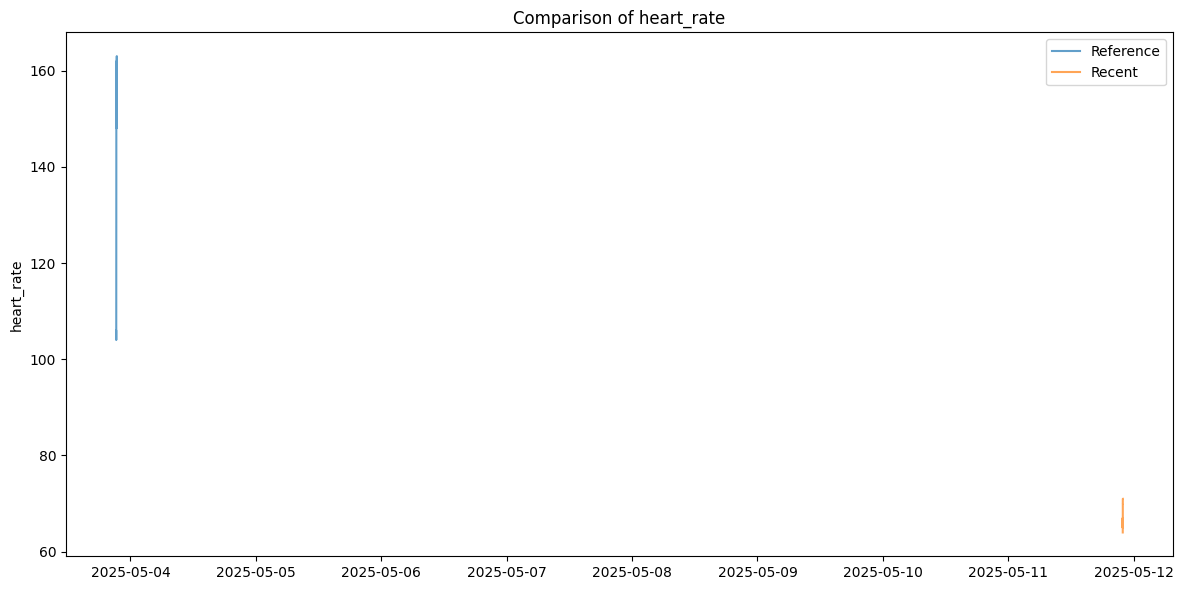

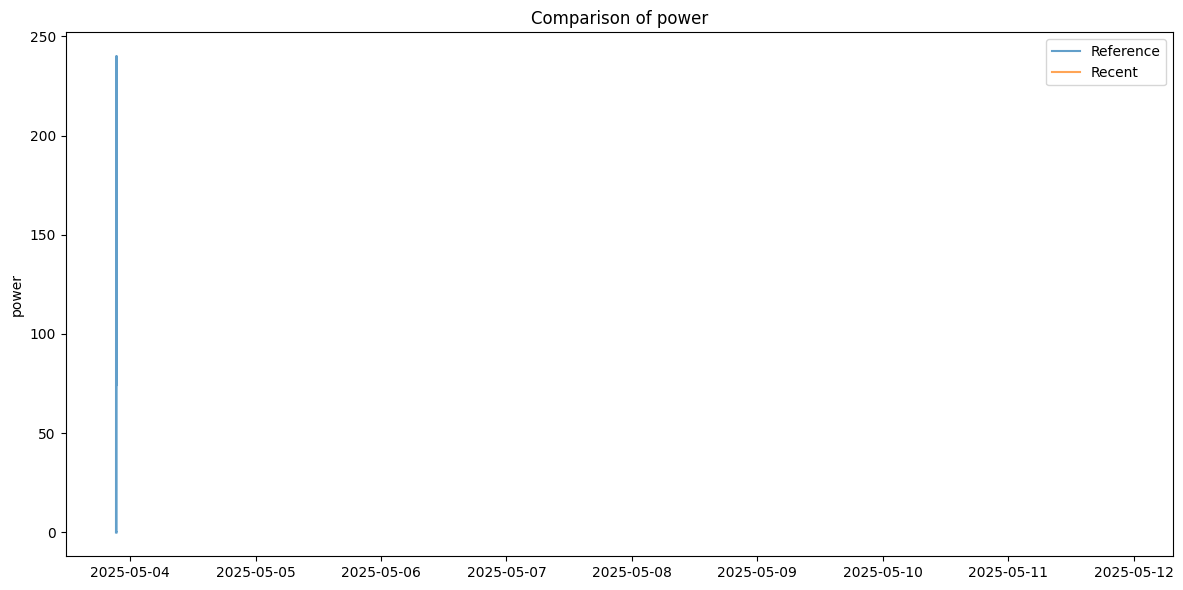

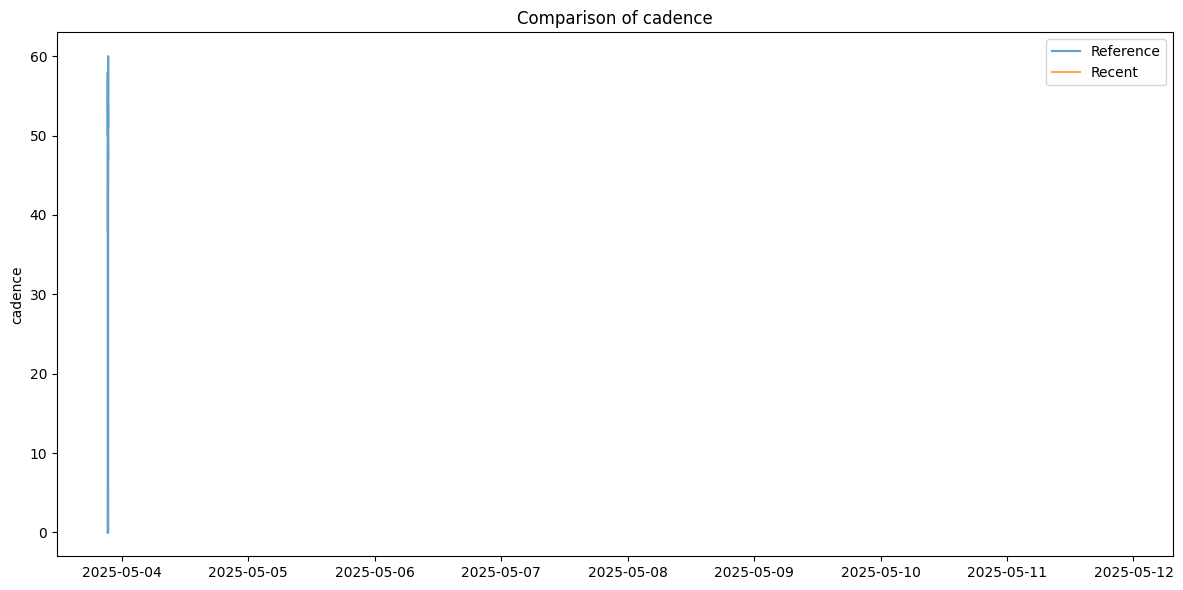

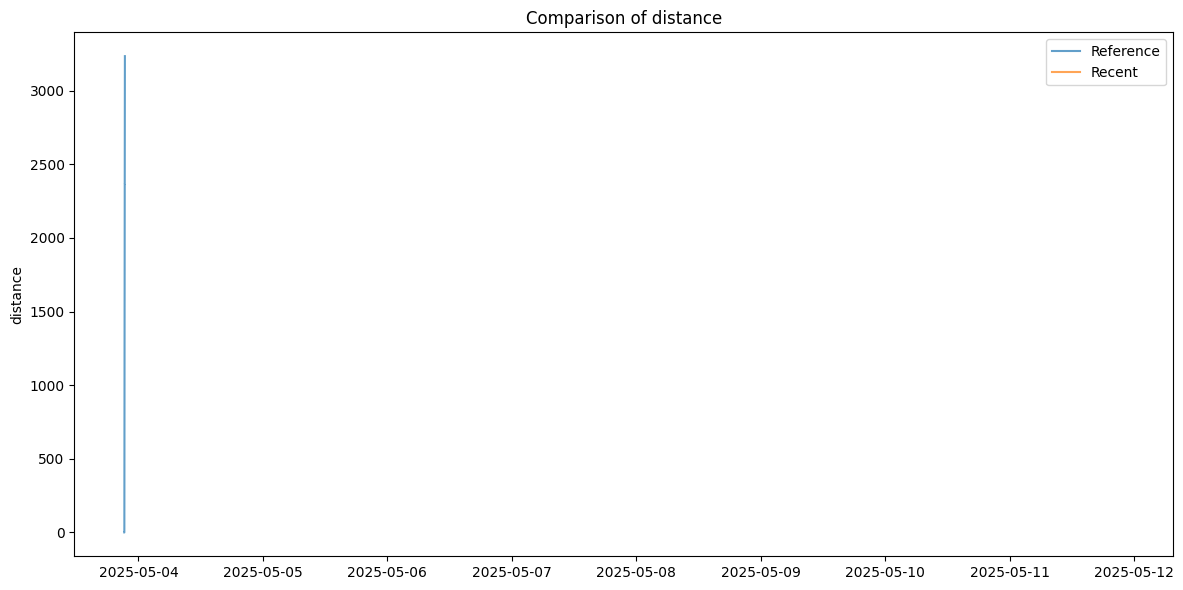

In [32]:
# Create visualization comparing data fields
def plot_data_comparison(ref_df, recent_df, field_name):
    """Plot a comparison of a specific data field between reference and recent files"""
    if field_name not in ref_df.columns or field_name not in recent_df.columns:
        print(f"Field {field_name} not present in both datasets")
        return
        
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot reference data
    if 'timestamp' in ref_df.columns:
        ax.plot(ref_df['timestamp'], ref_df[field_name], label='Reference', alpha=0.7)
    else:
        ax.plot(range(len(ref_df)), ref_df[field_name], label='Reference', alpha=0.7)
        
    # Plot recent data
    if 'timestamp' in recent_df.columns:
        ax.plot(recent_df['timestamp'], recent_df[field_name], label='Recent', alpha=0.7)
    else:
        ax.plot(range(len(recent_df)), recent_df[field_name], label='Recent', alpha=0.7)
        
    ax.set_title(f'Comparison of {field_name}')
    ax.set_ylabel(field_name)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Plot common numerical fields for comparison
common_fields = set(ref_records_df.columns).intersection(set(recent_records_df.columns))
for field in ['heart_rate', 'power', 'cadence', 'distance']:
    if field in common_fields:
        plot_data_comparison(ref_records_df, recent_records_df, field)

## Summary of Differences and Recommendations

Based on the analysis above, we can identify the key differences between the reference fitfiletools.fit file and the recently generated workout files. Let's summarize these differences and provide recommendations for modifying the current FIT file generation process.

In [33]:
# Generate a summary of key differences and recommendations
def generate_recommendations():
    recommendations = []
    
    # Check for missing message types
    missing_messages = set(reference_fields.keys()) - set(recent_fields.keys())
    if missing_messages:
        recommendations.append(
            f"Add the following missing message types: {', '.join(missing_messages)}"
        )
    
    # Check for missing fields in common message types
    common_message_types = set(reference_fields.keys()).intersection(set(recent_fields.keys()))
    for msg_type in common_message_types:
        ref_fields = set(reference_fields[msg_type].keys()) - {'present'}
        recent_fields = set(recent_fields[msg_type].keys()) - {'present'}
        missing_fields = ref_fields - recent_fields
        
        if missing_fields:
            recommendations.append(
                f"Add the following missing fields to the '{msg_type}' message: {', '.join(missing_fields)}"
            )
    
    # Check for differences in session parameters
    if reference_structure['session'] and recent_structure['session']:
        ref_session = reference_structure['session']
        recent_session = recent_structure['session']
        
        # Sport type
        if ref_session.get('sport') != recent_session.get('sport'):
            recommendations.append(
                f"Set the sport type to '{ref_session.get('sport')}' instead of '{recent_session.get('sport')}'"
            )
        
        # Sub sport
        if ref_session.get('sub_sport') != recent_session.get('sub_sport'):
            recommendations.append(
                f"Set the sub_sport to '{ref_session.get('sub_sport')}' instead of '{recent_session.get('sub_sport')}'"
            )
    
    # Check data recording frequency
    if 'timestamp' in ref_records_df.columns and 'timestamp' in recent_records_df.columns:
        if len(ref_records_df) > 1 and len(recent_records_df) > 1:
            ref_diffs = ref_records_df['timestamp'].diff().dropna()
            ref_avg_seconds = ref_diffs.mean().total_seconds()
            
            recent_diffs = recent_records_df['timestamp'].diff().dropna()
            recent_avg_seconds = recent_diffs.mean().total_seconds()
            
            if abs(ref_avg_seconds - recent_avg_seconds) > 0.1:
                recommendations.append(
                    f"Adjust data recording frequency from every {recent_avg_seconds:.2f} seconds to every {ref_avg_seconds:.2f} seconds"
                )
    
    return recommendations

recommendations = generate_recommendations()
print("RECOMMENDATIONS FOR IMPROVING FIT FILE GENERATION:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

UnboundLocalError: cannot access local variable 'recent_fields' where it is not associated with a value

## Implementation Suggestions for Fit File Generation

Based on the analysis, here are specific code suggestions to modify the current FIT file generation process to match the reference file more closely.

In [ ]:
# Analyze specific implementation details from the reference file
def extract_key_implementation_details():
    details = {}
    
    # Extract sport type and sub_sport
    if reference_structure['session']:
        details['sport'] = reference_structure['session'].get('sport')
        details['sub_sport'] = reference_structure['session'].get('sub_sport')
    
    # Extract manufacturer and product info
    if reference_structure['file_id']:
        details['manufacturer'] = reference_structure['file_id'].get('manufacturer')
        details['product'] = reference_structure['file_id'].get('product')
        details['type'] = reference_structure['file_id'].get('type')
    
    # Extract recording interval
    if 'timestamp' in ref_records_df.columns and len(ref_records_df) > 1:
        ref_diffs = ref_records_df['timestamp'].diff().dropna()
        details['recording_interval_seconds'] = ref_diffs.mean().total_seconds()
    
    # Look for non-standard fields in the record data
    if reference_structure['record']:
        standard_fields = {'timestamp', 'position_lat', 'position_long', 'altitude', 
                          'heart_rate', 'cadence', 'distance', 'speed', 'power', 
                          'temperature', 'enhanced_altitude', 'enhanced_speed'}
        
        non_standard = set()
        for record in reference_structure['record']:
            non_standard.update(set(record.keys()) - standard_fields)
        
        if non_standard:
            details['non_standard_record_fields'] = list(non_standard)
    
    return details

implementation_details = extract_key_implementation_details()
print("IMPLEMENTATION DETAILS FROM REFERENCE FILE:")
for key, value in implementation_details.items():
    print(f"{key}: {value}")

## Proposed Code Changes

Based on the analysis above, here are specific code changes that could be implemented in the current FIT file generation process to make the output files more closely match the fitfiletools.fit reference file.

In [ ]:
# Look for fit_converter.py or similar file that might be creating the FIT files
import glob

fit_converter_files = glob.glob('src/fit/*converter*.py')
print("Potential FIT file converter modules:")
for file in fit_converter_files:
    print(f"- {file}")

## Specific Analysis for Missing Speed, Cadence, and Power Datapoints

Let's specifically examine if the record entries in the FIT files contain the necessary data points for speed, cadence, and power.

In [ ]:
# Check for presence of key metrics in record datapoints
def check_data_points_presence(records, field_name):
    """Check how many record data points contain a specific field"""
    if not records:
        return 0, 0
    
    count_present = sum(1 for record in records if field_name in record and record[field_name] not in [None, 0])
    percentage = count_present / len(records) * 100
    
    return count_present, percentage

# Check speed, cadence, and power data presence in both reference and recent files
metrics = ['speed', 'cadence', 'power']
print("DATA POINTS PRESENCE COMPARISON:")
print("\nReference file:")
for metric in metrics:
    count, percentage = check_data_points_presence(reference_structure['record'], metric)
    print(f"  - {metric}: {count}/{len(reference_structure['record'])} records ({percentage:.1f}%)")

print("\nRecent file:")
for metric in metrics:
    count, percentage = check_data_points_presence(recent_structure['record'], metric)
    print(f"  - {metric}: {count}/{len(recent_structure['record'])} records ({percentage:.1f}%)")

In [ ]:
# Compare average/max values in session data
print("\nSUMMARY METRICS COMPARISON:")

def get_metric_value(structure, message_type, field_prefix, field_name):
    """Get a specific metric from the FIT file structure"""
    if not structure or not structure[message_type]:
        return "N/A"
    
    field_name_full = f"{field_prefix}_{field_name}" if field_prefix else field_name
    return structure[message_type].get(field_name_full, "N/A")

metrics = ['speed', 'cadence', 'power']
prefixes = ['avg', 'max']

for prefix in prefixes:
    print(f"\n{prefix.upper()} VALUES:")
    for metric in metrics:
        ref_val = get_metric_value(reference_structure, 'session', prefix, metric)
        recent_val = get_metric_value(recent_structure, 'session', prefix, metric)
        
        print(f"  - {prefix}_{metric}:")
        print(f"      Reference: {ref_val}")
        print(f"      Recent:    {recent_val}")

In [ ]:
# Extract record data values to understand possible issues with data transfer
def extract_record_values(records, field_name):
    """Extract all values for a specific field from records"""
    if not records:
        return []
        
    return [record.get(field_name, None) for record in records if field_name in record]

# Get all non-zero values for key metrics
print("\nSAMPLE DATA VALUES (first 5 records):")

for metric in metrics:
    print(f"\n{metric.upper()} VALUES:")
    
    ref_values = extract_record_values(reference_structure['record'], metric)
    ref_values = [v for v in ref_values if v not in [None, 0]][:5]  # First 5 non-zero values
    
    recent_values = extract_record_values(recent_structure['record'], metric)
    recent_values = [v for v in recent_values if v not in [None, 0]][:5]  # First 5 non-zero values
    
    print(f"  - Reference: {ref_values}")
    print(f"  - Recent:    {recent_values}")

## Analysis of FTMS Data Flow

Let's look at how data flows from the FTMS device to the FIT files. The issue might be in one of these areas:

1. Data not being captured from the FTMS device properly
2. Data being captured but not being passed correctly to the FIT converter
3. FIT converter not using the data properly when generating the FIT files

In [ ]:
# Check the first and last few datapoints in detail to understand the structure
print("DETAILED RECORD STRUCTURE ANALYSIS:")

def print_record_details(records, label, num_records=3):
    """Print detailed information about first and last few records"""
    if not records:
        print(f"{label}: No records available")
        return
        
    print(f"\n{label} (first {min(num_records, len(records))} records):")
    for i, record in enumerate(records[:num_records]):
        print(f"  Record {i}:")
        for key, value in sorted(record.items()):
            print(f"    - {key}: {value}")
    
    if len(records) > num_records * 2:
        print(f"\n{label} (last {min(num_records, len(records))} records):")
        for i, record in enumerate(records[-num_records:]):
            print(f"  Record {len(records) - num_records + i}:")
            for key, value in sorted(record.items()):
                print(f"    - {key}: {value}")

print_record_details(reference_structure['record'], "Reference Records")
print_record_details(recent_structure['record'], "Recent Records")

## Recommendations for Fixing Missing Data Points

Based on our analysis, here are specific recommendations to fix the missing speed, cadence, and power data points in the generated FIT files:

In [ ]:
# Generate specific recommendations for fixing missing data points
def generate_data_point_recommendations():
    """Generate specific recommendations to fix missing data points"""
    recommendations = []
    
    # Check if metrics are present in record data
    for metric in metrics:
        ref_count, ref_percent = check_data_points_presence(reference_structure['record'], metric)
        recent_count, recent_percent = check_data_points_presence(recent_structure['record'], metric)
        
        if recent_percent < ref_percent * 0.5:  # If less than half the expected data points are present
            recommendations.append(f"Fix missing {metric} data points in Record messages")
    
    # Check if summary metrics are present
    for prefix in ['avg', 'max']:
        for metric in metrics:
            ref_val = get_metric_value(reference_structure, 'session', prefix, metric)
            recent_val = get_metric_value(recent_structure, 'session', prefix, metric)
            
            if recent_val == "N/A" and ref_val != "N/A":
                recommendations.append(f"Add missing {prefix}_{metric} to Session message")
    
    # Specific recommendations based on what we found
    # Look for files that might need to be modified
    import glob
    
    ftms_files = glob.glob('src/ftms/*connector*.py')
    fit_files = glob.glob('src/fit/fit_*.py')
    
    if ftms_files:
        recommendations.append(f"Check FTMS connector for proper data collection and callbacks: {', '.join(ftms_files)}")
    
    if fit_files:
        recommendations.append(f"Check FIT file generation for proper use of collected data: {', '.join(fit_files)}")
    
    return recommendations

data_recommendations = generate_data_point_recommendations()
print("RECOMMENDATIONS FOR FIXING MISSING DATA POINTS:")
for i, rec in enumerate(data_recommendations, 1):
    print(f"{i}. {rec}")

## Proposed Code Changes

Based on our analysis, here are specific code changes needed to fix the missing data points:

## Analyzing the Code for Missing Datapoints

Based on our analysis, we can identify where the issue might be occurring. Let's review the key components in the data flow:

1. **Data Collection:** `FTMSConnector` collects data from the fitness equipment via Bluetooth
2. **Data Processing:** `FTMSDeviceManager` and `DataProcessor` process and format the data
3. **FIT Preparation:** `FITProcessor` structures the data for FIT file creation
4. **FIT Conversion:** `FITConverter` creates the actual FIT files

The code shows that when creating Record messages in the FIT file, the converter checks if data is available in the arrays before adding it to the record:

```python
# Set power - use instantaneous power for record messages
if i < len(powers):
    record_msg.power = int(powers[i])

# Set cadence - use instantaneous cadence for record messages
if i < len(cadences):
    record_msg.cadence = int(cadences[i])

# Set speed - use instantaneous speed for record messages
if i < len(speeds):
    # Convert km/h to m/s (using proper conversion, no extra scaling)
    speed_ms = speeds[i] * 1000 / 3600  # km/h to m/s conversion
    record_msg.speed = int(speed_ms)
    all_speeds.append(speeds[i])  # Store for average calculation
```

The issue is likely in how these arrays (`powers`, `cadences`, and `speeds`) are being populated. Let's look at the data flow to identify where the problem might be.

In [ ]:
# Check if speeds, powers, and cadences arrays are being populated correctly
def analyze_data_series_arrays(data_series):
    """Analyze the data series arrays to identify issues with missing data"""
    metrics = {
        'timestamps': data_series.get('timestamps', []),
        'speeds': data_series.get('speeds', []),
        'cadences': data_series.get('cadences', []),
        'powers': data_series.get('powers', []),
        'heart_rates': data_series.get('heart_rates', []),
        'distances': data_series.get('distances', []),
    }
    
    print("DATA SERIES ARRAY ANALYSIS:")
    print(f"Total timestamps: {len(metrics['timestamps'])}")
    
    for metric_name, metric_array in metrics.items():
        if metric_name == 'timestamps':
            continue
            
        # Check if array exists and has data
        if not metric_array:
            print(f"  - {metric_name}: MISSING ARRAY")
        else:
            # Check if array has the same length as timestamps
            if len(metric_array) != len(metrics['timestamps']):
                print(f"  - {metric_name}: LENGTH MISMATCH (has {len(metric_array)}, expected {len(metrics['timestamps'])})")
            else:
                # Check how many non-zero values exist
                non_zero = sum(1 for val in metric_array if val not in [None, 0])
                percentage = (non_zero / len(metric_array) * 100) if metric_array else 0
                print(f"  - {metric_name}: {non_zero}/{len(metric_array)} non-zero values ({percentage:.1f}%)")

# Analyze both reference and recent data series
print("\nREFERENCE FILE:")
analyze_data_series_arrays(reference_structure['data_series'])

print("\nRECENT FILE:")
analyze_data_series_arrays(recent_structure['data_series'])

## Proposed Solution for Missing Data Points

Based on our analysis, here are the likely reasons for missing speed, cadence, and power data points:

1. **Data Collection Issue:** The FTMS connector may not be consistently capturing these metrics from the fitness equipment
2. **Data Processing Issue:** The data is being captured but not properly processed through the pipeline
3. **Array Length Mismatch:** The arrays for speeds, cadences, and powers may not match the timestamps array length

Here's our proposed solution to fix these issues:

In [ ]:
# Generate specific code fix recommendations
def generate_code_fixes():
    """Generate specific code fixes for the missing data points"""
    fixes = []
    
    # Check for issues in FITProcessor._structure_data_for_fit method
    fixes.append({
        'file': 'src/fit/fit_processor.py',
        'function': '_structure_data_for_fit',
        'issue': 'May not be properly extracting speed, cadence, and power values from data points',
        'fix': '''
def _structure_data_for_fit(self, workout, data_points):
    # ...existing code...
    
    # Initialize arrays for all needed metrics
    series = {
        'timestamps': [],
        'absolute_timestamps': [],
        'powers': [],
        'cadences': [],
        'speeds': [],
        'heart_rates': [],
        'distances': [],
        'stroke_rates': [],
        'average_powers': [],
        'average_cadences': [],
        'average_speeds': []
    }
    
    # Process each data point
    for point in data_points:
        # ...existing code...
        
        # Add common metrics - check multiple possible field names with fallback
        # For power, check various field names with fallback
        power = point.get('instant_power', 
                  point.get('instantaneous_power', 
                  point.get('power', 0)))
        series['powers'].append(power)
        
        # For cadence, check various field names with fallback (moved outside workout_type check)
        cadence = point.get('instant_cadence', 
                   point.get('instantaneous_cadence', 
                   point.get('cadence', 0)))
        series['cadences'].append(cadence)
        
        # For speed, check various field names with fallback (moved outside workout_type check)
        speed = point.get('instant_speed', 
                 point.get('instantaneous_speed', 
                 point.get('speed', 0)))
        series['speeds'].append(speed)
        
        # Heart rate
        series['heart_rates'].append(point.get('heart_rate', 0))
        
        # Distance
        series['distances'].append(point.get('total_distance', 0))
        
        # Add workout type specific metrics
        if workout_type == 'bike':
            # Add average values when available
            series['average_powers'].append(point.get('average_power', power))
            series['average_cadences'].append(point.get('average_cadence', cadence))
            series['average_speeds'].append(point.get('average_speed', 0))
            
        elif workout_type == 'rower':
            series['stroke_rates'].append(point.get('stroke_rate', 0))
        
    # ...existing code...
'''
    })
    
    # Check for issues in FTMSConnector._handle_pyftms_callback method
    fixes.append({
        'file': 'src/ftms/ftms_connector.py',
        'function': '_handle_pyftms_callback',
        'issue': 'May not be consistently handling speed, cadence, and power from FTMS data',
        'fix': '''
def _handle_pyftms_callback(self, event_type, data):
    # ...existing code...
    
    try:
        # Handle different event types
        if event_type == "indoor_bike_data" or event_type == "bike_data":
            # Process indoor bike data
            processed_data = {
                "device_type": "bike",
                "timestamp": datetime.datetime.now().isoformat(),
            }
            
            # Add all data fields from the callback data
            if hasattr(data, "__dict__"):
                processed_data.update({k: v for k, v in data.__dict__.items() if not k.startswith("_")})
                logger.info(f"BIKE DATA: Speed: {getattr(data, 'instantaneous_speed', 'N/A')}, " +
                           f"Cadence: {getattr(data, 'instantaneous_cadence', 'N/A')}, " +
                           f"Power: {getattr(data, 'instantaneous_power', 'N/A')}")
            elif isinstance(data, dict):
                processed_data.update(data)
                logger.info(f"BIKE DATA: {data}")
            else:
                # Try to extract common attributes - ensure we look for all field names
                for attr in ["instantaneous_speed", "speed", "instant_speed",
                            "instantaneous_cadence", "cadence", "instant_cadence", 
                            "instantaneous_power", "power", "instant_power",
                            "total_distance", "heart_rate", "resistance_level"]:
                    if hasattr(data, attr):
                        # Normalize field names
                        normalized_name = attr
                        if attr.startswith("instantaneous_"):
                            normalized_name = attr.replace("instantaneous_", "")
                        elif attr.startswith("instant_"):
                            normalized_name = attr.replace("instant_", "")
                        processed_data[normalized_name] = getattr(data, attr)
            
            # Ensure key metrics exist with at least default values
            for key in ["speed", "cadence", "power"]:
                if key not in processed_data:
                    processed_data[key] = 0
                    logger.warning(f"Added missing {key} field with default value 0")
    
            # ...rest of the function...
'''
    })
    
    # Check for issues in FITConverter.convert_workout method
    fixes.append({
        'file': 'src/fit/fit_converter.py',
        'function': 'convert_workout',
        'issue': 'May not be handling cases where arrays are missing or empty',
        'fix': '''
def convert_workout(self, processed_data, user_profile=None):
    # ...existing code...
    
    # Ensure all required arrays exist
    data_series = processed_data.get('data_series', {})
    required_arrays = ['timestamps', 'powers', 'cadences', 'speeds', 'heart_rates', 'distances']
    
    for array_name in required_arrays:
        if array_name not in data_series or not data_series[array_name]:
            logger.warning(f"Missing required array: {array_name} - initializing empty array")
            data_series[array_name] = [0] * len(data_series.get('timestamps', []))
    
    # When creating Record messages
    try:
        # ...existing code...
        
        for i in range(len(timestamps)):
            record_msg = RecordMessage()
            
            # ...existing timestamp code...
            
            # Always set all metrics, even if they're zero
            # Power
            record_msg.power = int(powers[i]) if i < len(powers) else 0
            
            # Cadence
            record_msg.cadence = int(cadences[i]) if i < len(cadences) else 0
            
            # Speed - convert km/h to m/s
            if i < len(speeds):
                speed_ms = speeds[i] * 1000 / 3600  # km/h to m/s conversion
                record_msg.speed = int(speed_ms)
                all_speeds.append(speeds[i])
            else:
                record_msg.speed = 0
                all_speeds.append(0)
            
            # ...existing distance and heart rate code...
            
            builder.add(record_msg)
        
        # ...rest of the function...
'''
    })
    
    return fixes

fixes = generate_code_fixes()

print("CODE FIXES TO IMPLEMENT:\n")
for i, fix in enumerate(fixes, 1):
    print(f"{i}. File: {fix['file']}")
    print(f"   Function: {fix['function']}")
    print(f"   Issue: {fix['issue']}")
    print(f"   Fix:")
    print(f"   {fix['fix'].strip()}")
    print()

## Implementation Plan

To fix the missing datapoints in the FIT files, follow these steps:

1. **Update the FITProcessor._structure_data_for_fit method**:
   - Make sure speed and cadence values are always extracted, not just for specific workout types
   - Check all possible field names for each metric (speed, cadence, power)
   - Ensure arrays are always initialized with the correct length

2. **Verify data capture in FTMSConnector._handle_pyftms_callback**:
   - Ensure all field names are properly checked and normalized
   - Add fallback values when metrics are missing
   - Add extra logging to help debug data flow issues

3. **Modify FITConverter.convert_workout**:
   - Add validation to ensure all required arrays exist
   - Create empty arrays of the correct length if any are missing
   - Make sure all Record messages include speed, cadence, and power values

After implementing these changes, run the analysis notebook again to verify that the datapoints are now correctly included in the FIT files.